# Exercise 1

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import requests
import re
import matplotlib
%matplotlib inline
from enum import Enum
from bs4 import BeautifulSoup

The data can be fetched from IS-Academia usign a form. To automate this process we looked at the form  source code to find out what query is sent to the server to obtain the data. We found that the query is sent to http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter with the values of the form fields as request parameters (appended to the URL after a '?').

The first step is to find out the values correspondig to the parameters we're interested in. To do so we parse the form HTML with BeautifulSoup.

In [2]:
r = requests.get('http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2016-2017&ww_x_PERIODE_ACAD=355925344&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=null&dummy=ok')
soup = BeautifulSoup(r.text, 'html.parser')

In [3]:
def printFieldValues(field_name):
    for opt in soup.find('select', {'name': field_name}).find_all('option'):
        print(opt.string, "=", opt['value'])

The values of the different fields:

In [4]:
# Academic unit
print("=== Academic unit ===")
printFieldValues('ww_x_UNITE_ACAD')

# Academic period
print("\n\n=== Academic period ===")
printFieldValues('ww_x_PERIODE_ACAD')

# Pedagogic period
print("\n\n=== Pedagogic period ===")
printFieldValues('ww_x_PERIODE_PEDAGO')

=== Academic unit ===
None = null
Architecture = 942293
Chimie et génie chimique = 246696
Cours de mathématiques spéciales = 943282
EME (EPFL Middle East) = 637841336
Génie civil = 942623
Génie mécanique = 944263
Génie électrique et électronique  = 943936
Humanités digitales = 2054839157
Informatique = 249847
Ingénierie financière = 120623110
Management de la technologie = 946882
Mathématiques = 944590
Microtechnique = 945244
Physique = 945571
Science et génie des matériaux = 944917
Sciences et ingénierie de l'environnement = 942953
Sciences et technologies du vivant = 945901
Section FCUE = 1574548993
Systèmes de communication = 946228


=== Academic period ===
None = null
2016-2017 = 355925344
2015-2016 = 213638028
2014-2015 = 213637922
2013-2014 = 213637754
2012-2013 = 123456101
2011-2012 = 123455150
2010-2011 = 39486325
2009-2010 = 978195
2008-2009 = 978187
2007-2008 = 978181


=== Pedagogic period ===
None = null
Bachelor semestre 1 = 249108
Bachelor semestre 2 = 249114
Bachelor se

To make the code more readable we define enums containing these values:

In [5]:
# Define ISA codes

class AcademicUnit(Enum):
    Informatique = 249847
    
class AcademicPeriod(Enum):
    y20162017  =  355925344
    y20152016  =  213638028
    y20142015  =  213637922
    y20132014  =  213637754
    y20122013  =  123456101
    y20112012  =  123455150
    y20102011  =  39486325
    y20092010  =  978195
    y20082009  =  978187
    y20072008  =  978181
    
class PedagogicPeriod(Enum):
    Bachelor1  =  249108
    Bachelor2  =  249114
    Bachelor3  =  942155
    Bachelor4  =  942163
    Bachelor5  =  942120
    Bachelor6  =  942175

We now create a function to get the data matching a filter from ISA. To do so we send a request with the given parameters to obtain the filter and the mysterious "GPS" value and then query the resulting table.

In [6]:
def getDataTable(academicUnit, academicPeriod, pedagogicPeriod):
    """Get HTML table from ISA given filter values."""
    
    # URLs of ISA
    url1 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"
    url2 = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html"

    # Send a first request to obtain the "GPS" value
    payload1 = {
        'ww_b_list':'1',
        'ww_i_reportmodel':'133685247',
        'ww_c_langue':'',
        'ww_i_reportModelXsl':'133685270',
        'zz_x_UNITE_ACAD':'',
        'ww_x_UNITE_ACAD': academicUnit.value,
        'zz_x_PERIODE_ACAD':'',
        'ww_x_PERIODE_ACAD': academicPeriod.value,
        'zz_x_PERIODE_PEDAGO':'',
        'ww_x_PERIODE_PEDAGO': pedagogicPeriod.value,
        'zz_x_HIVERETE':'',
        'ww_x_HIVERETE': 'null',
        'dummy':'ok'
    }

    # Get the GPS value in the response (it is in the second link with "ww_x_GPS" class)
    r1 = requests.get(url1, payload1)
    soup = BeautifulSoup(r1.text, 'html.parser')
    gps = re.search("\d+",soup.find_all('a', {'class': 'ww_x_GPS'})[1]['onclick']).group(0)

    # Send the request to obtain the table
    payload2 = {
        'ww_x_GPS':gps,
        'ww_i_reportModel':'133685247',
        'ww_i_reportModelXsl':'133685270',
        'ww_x_UNITE_ACAD': academicUnit.value,
        'ww_x_PERIODE_ACAD': academicPeriod.value,
        'ww_x_PERIODE_PEDAGO': pedagogicPeriod.value,
        'ww_x_HIVERETE': 'null'
    }

    # Return the table
    r2 = requests.get(url2,payload2)
    soup = BeautifulSoup(r2.text, 'html.parser')
    
    return soup.find('table')


And then we create a function to build a DataFrame from the HTML table:

In [7]:
def parseTable(table, master=False):
    """Parses an HTML table from ISA and returns a dataframe with it's relevant content."""
    rows = map(lambda x: x.find_all('td'), table.find_all('tr')[2:])
    data = []
    
    for row in rows:
        if(master):
            data.append({'Civility': row[0].string, 'Name': row[1].string, 'Specialisation': row[4].string,
                         'Minor': row[6].string, 'Sciper': row[10].string})
        else:
            data.append({'Civility': row[0].string, 'Name': row[1].string, 'Sciper': row[10].string})
        
    return pd.DataFrame(data)
    

Now we can fetch bachelor student's data from ISA (takes a long time to execute, ~ 1 minute):

In [8]:
# This takes a long time to execute !

compiled_data = []

for year in AcademicPeriod:
    for semester in PedagogicPeriod:
        data = parseTable(getDataTable(AcademicUnit.Informatique, year, semester))
        data['Year'] = year.name
        data['Semester'] = semester.name
        compiled_data.append(data)
        
bachelor = pd.concat(compiled_data)
bachelor

,Civility,Name,Sciper,Year,Semester
0,Monsieur,Abbey Alexandre,235688,y20162017,Bachelor1
1,Monsieur,Ahn Seongho,274015,y20162017,Bachelor1
2,Madame,Alemanno Sara,268410,y20162017,Bachelor1
3,Monsieur,Althaus Luca,271464,y20162017,Bachelor1
4,Monsieur,Assi Karim,274518,y20162017,Bachelor1
5,Monsieur,Badoux Luc-Antoine,249613,y20162017,Bachelor1
6,Monsieur,Bagnoud Jérôme,262214,y20162017,Bachelor1
7,Monsieur,Barbaras Yann Quentin,262239,y20162017,Bachelor1
8,Monsieur,Barras Luca,257916,y20162017,Bachelor1
9,Madame,Barsi Clémence Marie Sabine,271508,y20162017,Bachelor1


Now that we have the data we can process it:
- First we filter out students that do not appear in semester 1 and 6,
- Then we count the number of semester they took for their bachelor,
- Finally we display the average duration by gender.

In [9]:
# Find out which students are registered in semester 1 and 6
bachelor1 = bachelor[bachelor['Semester'] == 'Bachelor1']
bachelor6 = bachelor[bachelor['Semester'] == 'Bachelor6']
bachelor_complete = pd.merge(bachelor1, bachelor6, how='inner', on=['Sciper'])['Sciper']

# Keep those from the whole list
bachelor_complete = bachelor[bachelor['Sciper'].isin(bachelor_complete)]

# Let's count how many semesters they took for their bachelor
bc_sem_count = bachelor_complete[['Sciper']].copy()
bc_sem_count['Month count'] = 6
bc_sem_count = bc_sem_count.groupby('Sciper').sum()

# Give them thier civility back
civilities = bachelor[['Sciper', 'Civility']].drop_duplicates()
bc_sem_count = civilities.join(bc_sem_count, how='inner', on='Sciper')

In [10]:
# Assumption: can't finish EPFL in less than 36 months (In this case there is only one dude that is filtered out)
bc_sem_count = bc_sem_count[bc_sem_count['Month count'] >= 36]

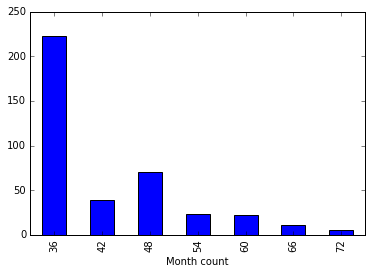

In [11]:
# Distribution of the number of month spent 
bc_sem_count[['Month count']].groupby('Month count').size().plot(kind='bar')

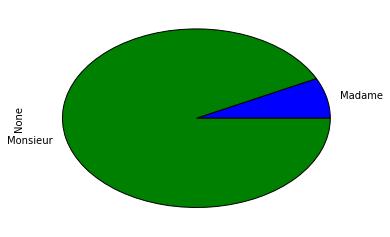

In [12]:
# Distribution of man vs woman
bc_sem_count.groupby('Civility').size().plot(kind='pie')

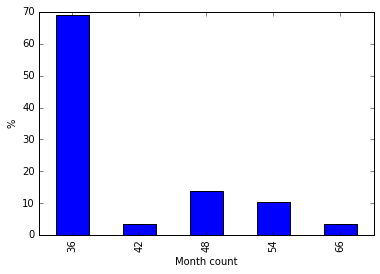

In [13]:
# Distribution for women
gpMa = bc_sem_count.groupby('Civility').get_group('Madame')
sMa = gpMa.count()[0]
ax = gpMa.groupby('Month count').size().map(lambda x: 100*x/sMa).plot(kind='bar')
ax.set_ylabel('%')

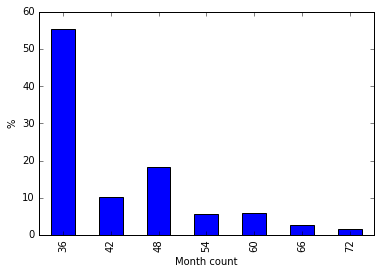

In [14]:
# Distribution for men
gpMo = bc_sem_count.groupby('Civility').get_group('Monsieur')
sMo = gpMo.count()[0]
ax = gpMo.groupby('Month count').size().map(lambda x: 100*x/sMo).plot(kind='bar')
ax.set_ylabel('%')

In [15]:
# Compute the average bachelor duration by gender
bc_sem_count.groupby('Civility').mean()

,Month count
Civility,
Madame,40.758621
Monsieur,42.686649


In [16]:
# std is different
bc_sem_count.groupby('Civility').std()

,Month count
Civility,
Madame,8.078433
Monsieur,9.182272


Finally we have to decide if the difference in the means is statistically significant. To do so we will use the p-value obtained by the Two-Sample T-Test. The p-value represents the probability to observe such a difference even if the two samples are equally distributed. The Two-Sample test assumes that the two data samples are independent which is a reasonable assumption as every student is unique and passes it's exams alone.

In [17]:
# Is the difference statistically significant ?

male = bc_sem_count[bc_sem_count['Civility'] == 'Monsieur']['Month count']
female = bc_sem_count[bc_sem_count['Civility'] == 'Madame']['Month count']

stats.ttest_ind(a= male, b= female, equal_var=False).pvalue

0.22927095396453992

With a p-value of ~22% we can see that it is not improbable to observe such a difference in the average bachelor duration if the null hypothesis is that the mean of the two groups are the same.

If we were using a 95% confidence level we would fail to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 5%.

# Exercise 2

Same as before but for the master:

In [18]:
class MasterPedagogicPeriod(Enum):
    Master1 = 2230106
    Master2 = 942192
    Master3 = 2230128
    #These next three are commented out because there is no data for them.
    #Master4 = 2230140
    #Mineur1 = 2335667
    #Mineur2 = 2335676
    MasterThesisFall = 249127
    MasterThesisSpring = 3781783

Acquire data for Master students. This takes quite some time.

In [19]:
compiled_data = []

for year in AcademicPeriod:
    for semester in MasterPedagogicPeriod:
        data = parseTable(getDataTable(AcademicUnit.Informatique, year, semester), True)
        data['Year'] = year.name
        data['Semester'] = semester.name
        compiled_data.append(data)
        
master = pd.concat(compiled_data)
master

,Civility,Minor,Name,Sciper,Semester,Specialisation,Year
0,Monsieur,None,Adams Marc Alain,271331,Master1,None,y20162017
1,Monsieur,None,Adamsons Valdis,273101,Master1,None,y20162017
2,Monsieur,None,Agapiou Stylianos,267543,Master1,None,y20162017
3,Monsieur,None,Aiulfi Loris Sandro,202293,Master1,None,y20162017
4,Monsieur,None,Alfonso Peterssen Alfonso,228219,Master1,Foundations of Software,y20162017
5,Monsieur,None,Angerand Grégoire Georges Jacques,212464,Master1,None,y20162017
6,Monsieur,None,Anongba Varela Dario Abougnan,226371,Master1,Software Systems,y20162017
7,Monsieur,None,Aquil Mohammad Amimul Ihsan,273107,Master1,Foundations of Software,y20162017
8,Monsieur,None,Bao Junze,266983,Master1,None,y20162017
9,Monsieur,None,Barbera Antonino,273118,Master1,None,y20162017


We are looking for people that have finished their master, or that are finishing it this semester. That is:
* People that are not registered this year
* People that are finishing their master this semester, i.e. people that are in their master thesis    

In [40]:
master_incomplete = master[(master["Year"] == "y20162017") & (master["Semester"] != "MasterThesisFall")]
master_complete = master[~master["Sciper"].isin(master_incomplete["Sciper"])]
master_complete_sem = master_complete.groupby("Sciper").size()
master_complete_scipers = master_complete_sem[master_complete_sem > 1]
# Here we drop people that are not registered at least for 2 semesters 

In [41]:
scipers_frame = master_complete_scipers.to_frame()
scipers_frame.columns = ["Month_count"]
scipers_frame["Month_count"] = scipers_frame["Month_count"]*6
# Rename the column and multiply by 6 (number of month per semester)

In [42]:
civilities_master = master_complete[["Civility", "Name", "Sciper", "Minor", "Specialisation"]].drop_duplicates()

In [46]:
# Join the tables to get all the columns back
master_complete = civilities_master.join(scipers_frame, how='inner', on='Sciper')

,Civility,Name,Sciper,Minor,Specialisation,Month_count
0,Monsieur,Amiguet Jérôme,166075,None,None,30
1,Monsieur,Antognini Diego Matteo,243163,None,None,18
2,Monsieur,Antognini Marco,194182,None,Foundations of Software,42
2,Monsieur,Antognini Marco,194182,None,None,42
3,Monsieur,Bouquet Stéphane,213664,"Mineur en Management, technologie et entrepren...",None,30
9,Monsieur,Bouquet Stéphane,213664,None,None,30
4,Monsieur,Bovet Sidney,214637,None,None,30
11,Monsieur,Bovet Sidney,214637,None,Internet computing,30
5,Monsieur,Brechbühler Gil,243164,None,None,30
6,Monsieur,Canale Raffaele,203947,None,None,30


,Civility,Name,Sciper,Minor,Specialisation,Month_count
2,Monsieur,Antognini Marco,194182,None,Foundations of Software,42
3,Monsieur,Bouquet Stéphane,213664,"Mineur en Management, technologie et entrepren...",None,30
11,Monsieur,Bovet Sidney,214637,None,Internet computing,30
7,Monsieur,Cao Huu-Ân,203945,"Mineur en Management, technologie et entrepren...",None,30
8,Monsieur,Cardoso Rodrigues Bonifácio Vítor Gonçalo,244136,"Mineur en Management, technologie et entrepren...",None,30
13,Monsieur,Duhem Martin Nicolas,214632,None,Foundations of Software,30
14,Monsieur,El Houti Youssef,194328,None,Information Security - SP,30
16,Monsieur,Engilberge Martin Pierre,212790,None,Internet computing,30
18,Monsieur,Favrod Philémon Orphée,218353,None,Computer Engineering - SP,30
22,Monsieur,Gaspoz John,212859,None,Information Security - SP,30


In [79]:
# Get the ones with a Minor or Spe, those one need to have spent at least 3 semesters at EPFL
# Get also the ones that did not do any spe or minor
minor_or_spe = master_complete[(~master_complete["Minor"].isnull()) | (~master_complete["Specialisation"].isnull())]
minor_or_spe_filtered = minor_or_spe[minor_or_spe['Month_count'] >= 6*3]
not_minor_or_spe = master_complete[~master_complete["Sciper"].isin(minor_or_spe["Sciper"])]
# Remove the ones that did 2 minor or spe
master_finished = pd.concat([minor_or_spe_filtered, not_minor_or_spe]).drop_duplicates(subset=['Sciper'])

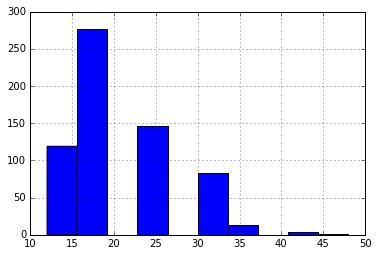

In [90]:
master_finished['Month_count'].hist()

In [81]:
# Calculate "average stay at EPFL"
master_finished['Month_count'].mean()

20.364485981308412

In [94]:
# Get the people that did a Spécialisation
spe = master_finished[(~master_finished["Specialisation"].isnull())]
spe[['Specialisation','Month_count']].groupby('Specialisation').mean()

,Month_count
Specialisation,
Biocomputing,25.500000
Computer Engineering - SP,21.428571
Foundations of Software,23.884615
Information Security - SP,30.000000
Internet computing,23.333333
Service science,22.000000
"Signals, Images and Interfaces",25.090909
Software Systems,22.666667
